In [1]:
import os
import csv
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
from fancyimpute import KNN, SoftImpute, IterativeImputer
from sklearn.preprocessing import Imputer

Using TensorFlow backend.


首先进行数据导入，本次为cbg的数据处理，将数值属性与标称属性进行分类导入
人口普查区块组（CBG）是美国人口普查局报告数据的最精细级别，涵盖约1500个家庭

In [2]:
#读入文件
df = pd.read_csv(os.path.dirname(os.getcwd()) + '\cbg_patterns.csv', encoding='utf-8')

In [3]:
num_index_list = ['census_block_group', 'date_range_start', 'date_range_end',
              'raw_visit_count', 'raw_visitor_count', 'distance_from_home']
normal_index_list = ['visitor_home_cbgs', 'visitor_work_cbgs', 'related_same_day_brand',
              'related_same_month_brand', 'top_brands', 'popularity_by_hour',
             'popularity_by_day']

对标称属性的频数进行输出

In [4]:
for index in normal_index_list:
    print(index)
    print(df[index].value_counts())

visitor_home_cbgs
{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   51152
{"170318391001":53}                                                                                                                                                                                                                                                                                                                                                                          

[]                                                                                                                                                                                     2983
["SmartStyle Family Hair Salons"]                                                                                                                                                       335
["Department of Veterans Affairs"]                                                                                                                                                      156
["H&R Block"]                                                                                                                                                                           134
["Sprint"]                                                                                                                                                                              112
["MasterCuts"]                                              

popularity_by_hour
[]                                                                                                                                                   106
[2659,2589,2508,2580,2773,3582,5058,5353,5084,5506,5863,6177,6560,6530,6752,7303,8086,7993,7106,6066,5266,4521,3825,3047]                              1
[4702,4639,4559,4486,4541,4994,5626,5707,5073,5113,5139,5530,5912,5589,5526,6155,7292,7122,6304,6057,5640,5235,5185,4872]                              1
[1032,1009,964,986,1052,1070,1215,2018,2227,2184,2135,2234,2224,2173,2233,2355,2189,2094,1694,1515,1423,1266,1138,1065]                                1
[19669,19048,18907,18786,18994,20912,30116,33802,29662,25869,25926,26746,27608,27600,29658,31869,34495,36219,33179,29502,27566,25381,22307,20717]      1
[6007,5114,4770,4724,4811,5860,10922,17869,17831,13213,13988,14904,16959,17044,18630,20376,23964,25640,23738,18536,15407,12350,9294,7165]              1
[996,992,961,958,956,967,1074,1096,1228,892,707,739,715,704,680

{}                                                                                                                    106
{"Monday":7752,"Tuesday":8215,"Wednesday":8452,"Thursday":6616,"Friday":7538,"Saturday":6545,"Sunday":6091}             1
{"Monday":8356,"Tuesday":8759,"Wednesday":8330,"Thursday":7057,"Friday":8356,"Saturday":7088,"Sunday":5864}             1
{"Monday":7211,"Tuesday":7640,"Wednesday":7325,"Thursday":6289,"Friday":6630,"Saturday":5754,"Sunday":4383}             1
{"Monday":2882,"Tuesday":2793,"Wednesday":2924,"Thursday":2234,"Friday":2493,"Saturday":2191,"Sunday":1935}             1
{"Monday":6167,"Tuesday":6267,"Wednesday":6041,"Thursday":4896,"Friday":5412,"Saturday":5075,"Sunday":4629}             1
{"Monday":1465,"Tuesday":1548,"Wednesday":1544,"Thursday":1271,"Friday":1216,"Saturday":1173,"Sunday":1010}             1
{"Monday":6927,"Tuesday":7270,"Wednesday":7143,"Thursday":6126,"Friday":6871,"Saturday":5574,"Sunday":4852}             1
{"Monday":8094,"Tuesday"

数值属性部分的处理
1、进行数值的数据摘要分析
分别对数值属性的均值、最大值、最小值、中位数、四分位点、缺失值进行统计

In [5]:
#分别对数值属性的均值、最大值、最小值、中位数、四分位点、缺失值进行统计
for index in num_index_list:
    print(index, ' mean: ', df[index].mean())
    print(index, ' max: ', df[index].max())
    print(index, ' min: ', df[index].min())
    print(index, ' median: ', df[index].median())
    print(index, ' four percentile: ', df[index].quantile(.25))
    print(index, ' null: ', df[index].isnull().sum())

census_block_group  mean:  287086382055.24207
census_block_group  max:  780309900000.0
census_block_group  min:  10010201001.0
census_block_group  median:  290190012013.5
census_block_group  four percentile:  131210116244.25
census_block_group  null:  1
date_range_start  mean:  1538352000.0
date_range_start  max:  1538352000
date_range_start  min:  1538352000
date_range_start  median:  1538352000.0
date_range_start  four percentile:  1538352000.0
date_range_start  null:  0
date_range_end  mean:  1541030400.0
date_range_end  max:  1541030400
date_range_end  min:  1541030400
date_range_end  median:  1541030400.0
date_range_end  four percentile:  1541030400.0
date_range_end  null:  0
raw_visit_count  mean:  47930.65965036328
raw_visit_count  max:  7179900.0
raw_visit_count  min:  60.0
raw_visit_count  median:  30640.0
raw_visit_count  four percentile:  17042.0
raw_visit_count  null:  106
raw_visitor_count  mean:  11820.319921678474
raw_visitor_count  max:  6113949.0
raw_visitor_count  min

进行画图功能代码编写

In [6]:
#数值属性直方图
def hist_plot(df, type_name):
    for index in num_index_list:
        df[index].hist(edgecolor='black')
        my_x_ticks = np.arange(df[index].min(), df[index].max(), (df[index].max() - df[index].min() + 10) // 10)
        plt.xticks(my_x_ticks)
        plt.title(index + " / " + type_name)
        plt.show()
        print(df[index].value_counts())

In [7]:
#数值属性qq图
def qq_plot(df, type_name):
    for index in num_index_list:
        stats.probplot(df[index], dist="norm", plot = plt)
        plt.title(index + " / " + type_name)
        plt.show()

In [8]:
#数值属性盒图
def box_plot(df, type_name):
    for index in num_index_list:
        plt.title(index + " / " + type_name)
        df[index].plot.box()
        plt.show()

对原数据不做改变，直接画直方图、qq图、盒图的结果

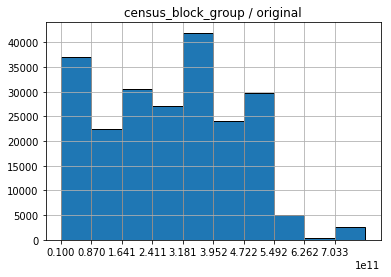

4.013422e+10    1
5.100109e+11    1
4.201101e+11    1
1.703180e+11    1
4.200760e+11    1
3.703501e+11    1
4.504100e+11    1
3.715704e+11    1
5.403303e+11    1
1.810500e+11    1
2.716307e+11    1
5.170003e+11    1
3.605500e+11    1
1.051030e+10    1
2.502354e+11    1
8.069003e+10    1
8.031004e+10    1
3.200301e+11    1
8.031007e+10    1
2.701596e+11    1
1.051031e+10    1
4.200595e+11    1
6.061021e+10    1
1.915300e+11    1
4.014301e+11    1
1.205701e+11    1
4.808503e+11    1
6.059110e+10    1
5.176002e+11    1
4.716502e+11    1
               ..
6.037107e+10    1
1.205701e+11    1
1.705195e+11    1
3.500100e+11    1
2.109300e+11    1
4.004138e+11    1
1.208601e+11    1
4.504500e+11    1
3.403126e+11    1
3.403118e+11    1
1.073010e+10    1
1.201104e+11    1
3.605500e+11    1
1.003011e+10    1
4.210103e+11    1
4.202930e+11    1
6.065042e+10    1
1.210303e+11    1
4.802912e+11    1
4.106703e+11    1
3.402971e+11    1
2.205102e+11    1
5.603300e+11    1
4.802702e+11    1
1.814101e+

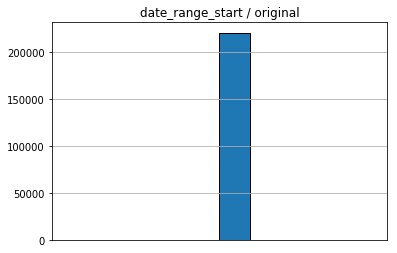

1538352000    220735
Name: date_range_start, dtype: int64


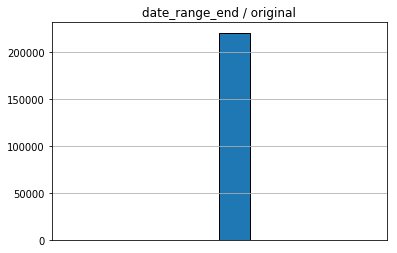

1541030400    220735
Name: date_range_end, dtype: int64


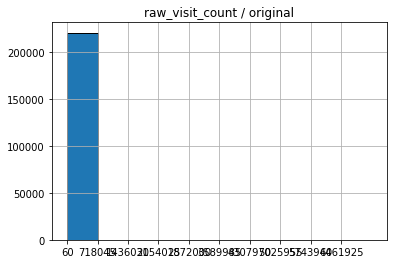

24531.0     15
12455.0     14
10888.0     14
21721.0     14
17801.0     13
16773.0     13
8524.0      13
15073.0     13
15161.0     13
11894.0     13
12980.0     13
17421.0     13
14482.0     13
12961.0     13
25796.0     13
16747.0     13
17567.0     13
15378.0     13
27618.0     13
21836.0     13
19911.0     13
15338.0     12
17419.0     12
11389.0     12
20390.0     12
12812.0     12
18861.0     12
25127.0     12
16338.0     12
14154.0     12
            ..
60669.0      1
108235.0     1
60670.0      1
94432.0      1
91460.0      1
81846.0      1
88565.0      1
153513.0     1
85144.0      1
471996.0     1
143524.0     1
153526.0     1
59418.0      1
67664.0      1
350032.0     1
80070.0      1
88559.0      1
58315.0      1
123050.0     1
78798.0      1
177120.0     1
935.0        1
76759.0      1
124678.0     1
3878.0       1
76758.0      1
192152.0     1
21082.0      1
49295.0      1
11783.0      1
Name: raw_visit_count, Length: 93774, dtype: int64


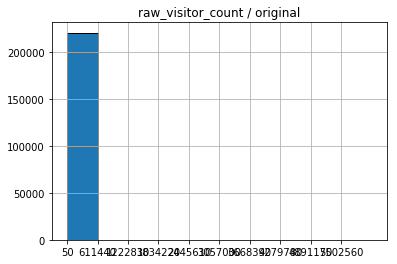

2292.0     39
3302.0     37
3106.0     36
3461.0     36
2444.0     36
2491.0     35
3255.0     35
2344.0     35
1615.0     35
1999.0     35
3584.0     35
1886.0     35
3230.0     35
3952.0     35
2754.0     35
2733.0     35
2133.0     35
2731.0     35
1866.0     34
2326.0     34
2894.0     34
2598.0     34
3334.0     34
3826.0     34
3530.0     34
2472.0     34
2315.0     33
3162.0     33
3799.0     33
2081.0     33
           ..
25932.0     1
76992.0     1
38935.0     1
77913.0     1
13972.0     1
19479.0     1
67794.0     1
52301.0     1
46105.0     1
26585.0     1
55331.0     1
82152.0     1
25435.0     1
46109.0     1
38937.0     1
27661.0     1
34342.0     1
58470.0     1
23057.0     1
14898.0     1
55325.0     1
20594.0     1
25933.0     1
429.0       1
23708.0     1
32405.0     1
62495.0     1
163.0       1
55329.0     1
18294.0     1
Name: raw_visitor_count, Length: 41483, dtype: int64


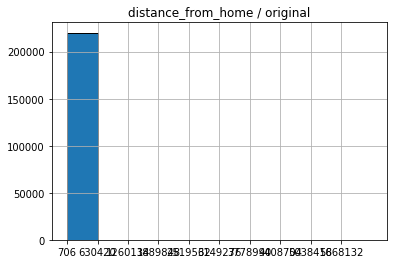

8345.0      30
8198.0      27
7422.0      27
8073.0      27
8337.0      25
8148.0      25
7579.0      24
8391.0      24
7494.0      24
8172.0      24
9230.0      23
7873.0      23
10270.0     23
7791.0      23
8202.0      23
6826.0      23
8802.0      23
8282.0      23
7485.0      23
8310.0      23
7469.0      23
7900.0      23
8554.0      22
7037.0      22
6817.0      22
8334.0      22
8038.0      22
10130.0     22
6692.0      22
8293.0      22
            ..
38271.0      1
114093.0     1
325295.0     1
56666.0      1
114089.0     1
250454.0     1
71200.0      1
114101.0     1
162670.0     1
228242.0     1
228225.0     1
46672.0      1
46083.0      1
36398.0      1
456473.0     1
40675.0      1
162699.0     1
114117.0     1
81347.0      1
128311.0     1
128313.0     1
162683.0     1
456433.0     1
81340.0      1
38270.0      1
57053.0      1
142012.0     1
29289.0      1
191089.0     1
188528.0     1
Name: distance_from_home, Length: 70557, dtype: int64


In [9]:
hist_plot(df, "original")

data_range_start（起始时间）与date_range_end（结束时间）均为同一个数值
census_block_group的分布较为平均
raw_visit_count、raw_visitor_count、distance_from_home在某一区间分布较大，剩余区间分布很少

d:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
d:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
d:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


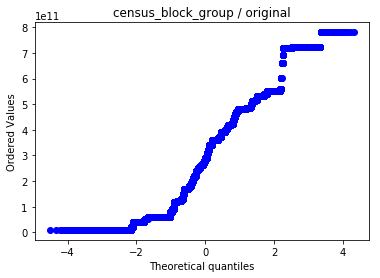

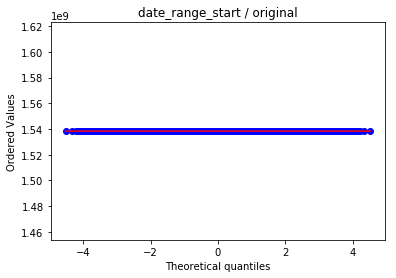

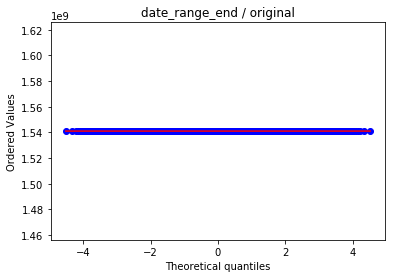

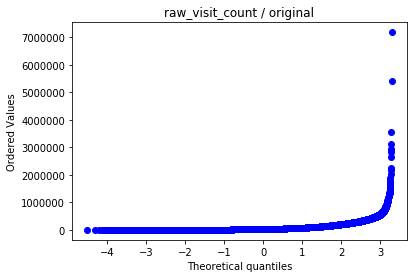

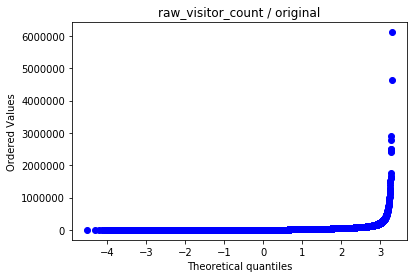

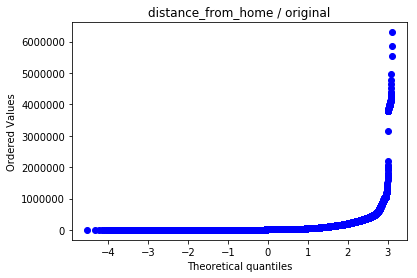

In [10]:
qq_plot(df, "original")

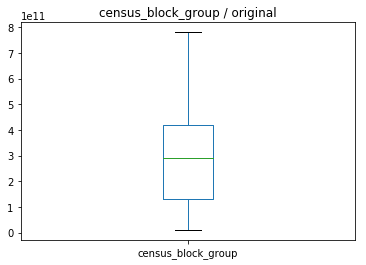

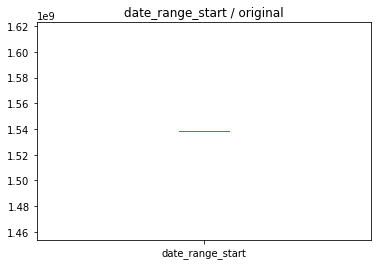

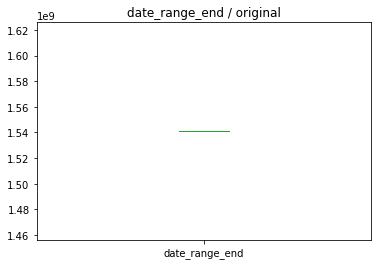

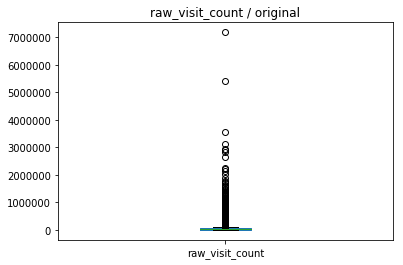

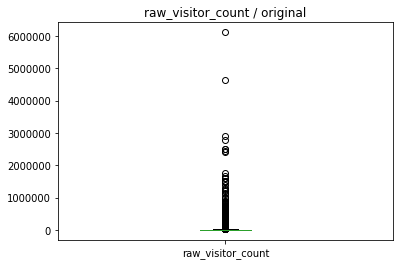

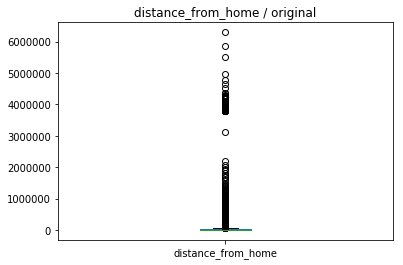

In [11]:
box_plot(df, "original")

对原数据缺失值进行剔除后画图结果

In [12]:
#数值属性(将缺失部分剔除)
df_delete = df.dropna(inplace=False)

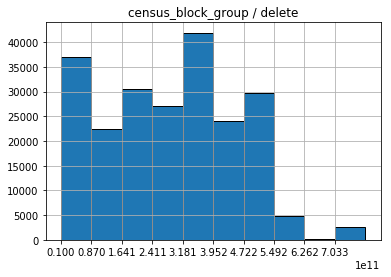

4.013422e+10    1
3.605500e+11    1
2.502354e+11    1
8.069003e+10    1
8.031004e+10    1
3.200301e+11    1
8.031007e+10    1
2.701596e+11    1
1.051031e+10    1
4.200595e+11    1
6.061021e+10    1
1.915300e+11    1
4.014301e+11    1
3.606102e+11    1
6.059110e+10    1
2.210595e+11    1
5.506300e+11    1
3.915170e+11    1
4.209121e+11    1
4.005002e+10    1
4.201100e+11    1
3.719396e+11    1
2.014309e+11    1
2.911907e+11    1
2.100197e+11    1
1.051030e+10    1
5.170003e+11    1
3.200300e+11    1
2.716307e+11    1
2.300997e+11    1
               ..
4.707997e+11    1
1.809736e+11    1
3.402100e+11    1
5.003960e+10    1
6.085504e+10    1
5.303301e+11    1
9.009343e+10    1
1.701395e+11    1
2.604901e+11    1
3.402704e+11    1
2.404501e+11    1
3.402705e+11    1
4.204541e+11    1
4.013619e+10    1
6.037232e+10    1
6.037104e+10    1
1.500301e+11    1
2.403380e+11    1
1.705195e+11    1
6.001095e+11    1
1.323101e+11    1
3.610317e+11    1
8.077000e+10    1
4.019003e+10    1
3.605930e+

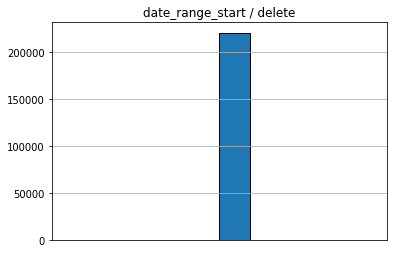

1538352000    220518
Name: date_range_start, dtype: int64


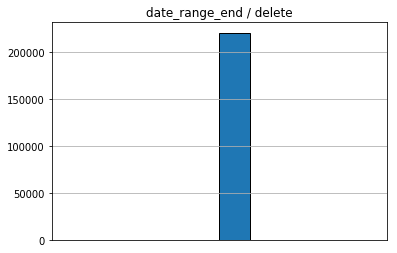

1541030400    220518
Name: date_range_end, dtype: int64


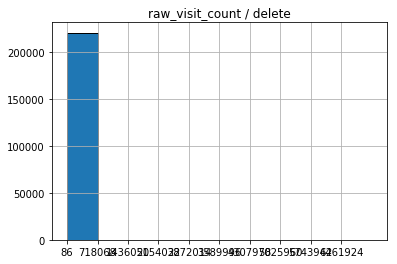

24531.0     15
12455.0     14
21721.0     14
10888.0     14
19911.0     13
12980.0     13
27618.0     13
12961.0     13
15378.0     13
17801.0     13
11894.0     13
15073.0     13
16747.0     13
17567.0     13
14482.0     13
16773.0     13
21836.0     13
25796.0     13
17421.0     13
8524.0      13
15161.0     13
15653.0     12
16796.0     12
18529.0     12
13479.0     12
20390.0     12
18861.0     12
17222.0     12
20541.0     12
11389.0     12
            ..
115701.0     1
153495.0     1
76747.0      1
34280.0      1
121335.0     1
48644.0      1
65323.0      1
88559.0      1
47776.0      1
80070.0      1
58315.0      1
58521.0      1
78798.0      1
46063.0      1
121322.0     1
76759.0      1
124678.0     1
72614.0      1
76758.0      1
192152.0     1
21082.0      1
177110.0     1
471996.0     1
153513.0     1
85144.0      1
143524.0     1
219903.0     1
109523.0     1
350032.0     1
11783.0      1
Name: raw_visit_count, Length: 93707, dtype: int64


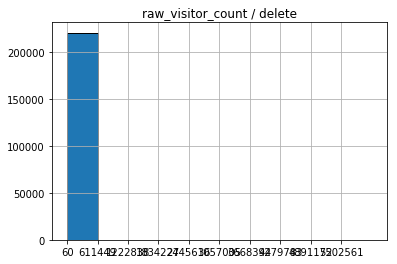

2292.0      39
3302.0      37
3106.0      36
3461.0      36
2444.0      36
3255.0      35
2133.0      35
1999.0      35
2731.0      35
1886.0      35
2733.0      35
2491.0      35
2754.0      35
3230.0      35
1615.0      35
3584.0      35
2344.0      35
3952.0      35
2598.0      34
2472.0      34
2326.0      34
2894.0      34
3826.0      34
3334.0      34
3530.0      34
1866.0      34
2309.0      33
3799.0      33
2115.0      33
3446.0      33
            ..
221356.0     1
77911.0      1
32405.0      1
76992.0      1
77913.0      1
19587.0      1
19479.0      1
67794.0      1
52301.0      1
23050.0      1
55331.0      1
82152.0      1
13972.0      1
33332.0      1
23711.0      1
20106.0      1
38935.0      1
38937.0      1
27661.0      1
34342.0      1
62495.0      1
46109.0      1
55325.0      1
25435.0      1
25933.0      1
23708.0      1
22903.0      1
163.0        1
55329.0      1
31632.0      1
Name: raw_visitor_count, Length: 41447, dtype: int64


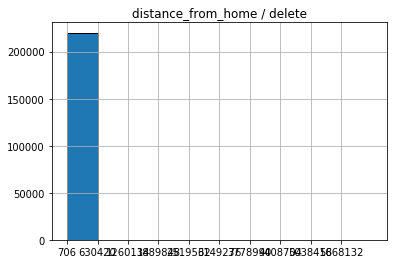

8345.0      30
8198.0      27
7422.0      27
8073.0      27
8337.0      25
8148.0      25
7579.0      24
8391.0      24
7494.0      24
8172.0      24
9230.0      23
7873.0      23
10270.0     23
7791.0      23
8202.0      23
6826.0      23
8802.0      23
8282.0      23
7485.0      23
8310.0      23
7469.0      23
7900.0      23
8554.0      22
7037.0      22
6817.0      22
8334.0      22
8038.0      22
10130.0     22
6692.0      22
8293.0      22
            ..
38271.0      1
114093.0     1
325295.0     1
56666.0      1
114089.0     1
250454.0     1
71200.0      1
114101.0     1
162670.0     1
228242.0     1
228225.0     1
46672.0      1
46083.0      1
36398.0      1
456473.0     1
40675.0      1
162699.0     1
114117.0     1
81347.0      1
128311.0     1
128313.0     1
162683.0     1
456433.0     1
81340.0      1
38270.0      1
57053.0      1
142012.0     1
29289.0      1
191089.0     1
188528.0     1
Name: distance_from_home, Length: 70557, dtype: int64


In [13]:
hist_plot(df_delete, "delete")

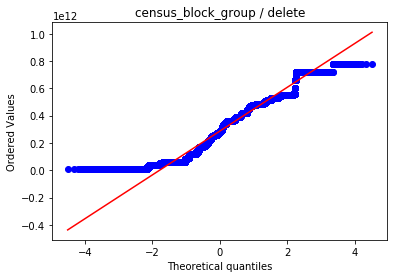

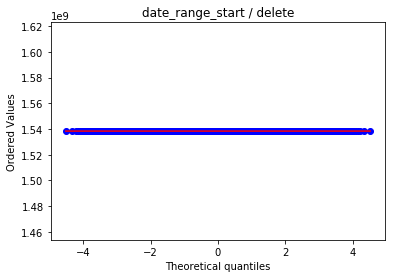

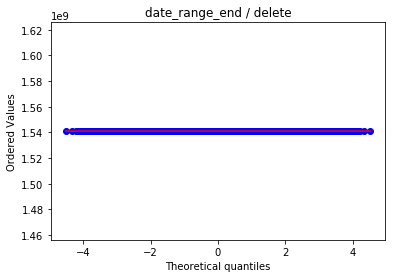

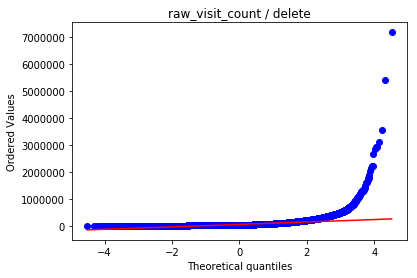

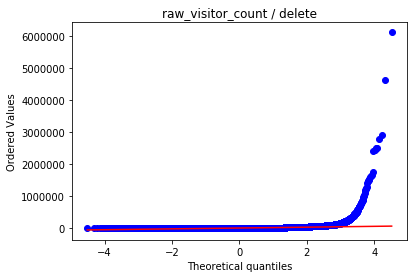

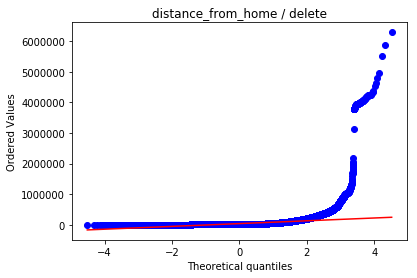

In [14]:
qq_plot(df_delete, "delete")

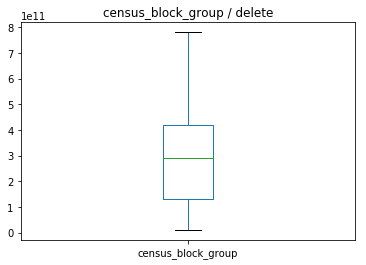

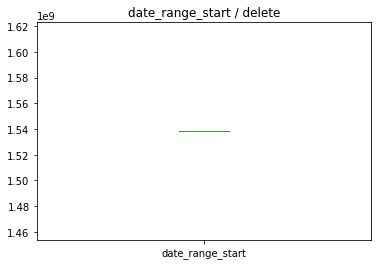

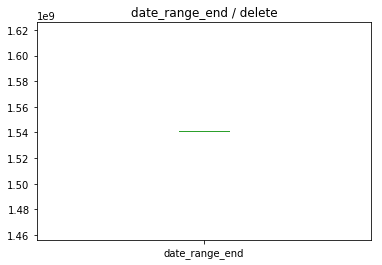

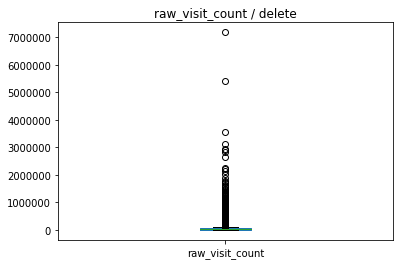

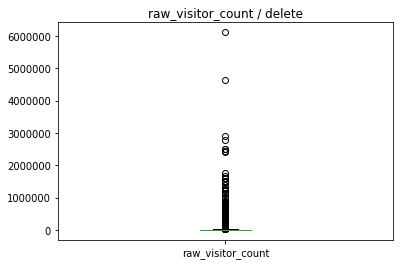

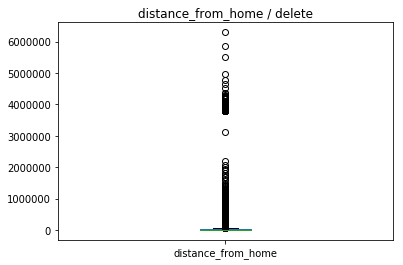

In [15]:
box_plot(df_delete, "delete")

数值属性(用最高频率值来填补缺失值)，画图结果

In [16]:
#数值属性(用最高频率值来填补缺失值)
df_argmax = df.copy()
for index in num_index_list:
    df_argmax[index] = df_argmax[index].fillna(df_argmax[index].mode()[0])

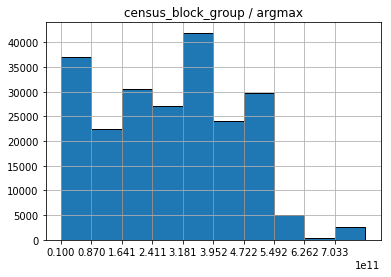

1.001020e+10    2
4.013422e+10    1
3.605500e+11    1
4.201101e+11    1
1.703180e+11    1
4.200760e+11    1
3.703501e+11    1
4.504100e+11    1
3.715704e+11    1
5.403303e+11    1
1.810500e+11    1
2.716307e+11    1
5.170003e+11    1
1.051030e+10    1
2.916947e+11    1
2.502354e+11    1
8.069003e+10    1
8.031004e+10    1
3.200301e+11    1
8.031007e+10    1
2.701596e+11    1
1.051031e+10    1
4.200595e+11    1
6.061021e+10    1
1.915300e+11    1
4.014301e+11    1
1.205701e+11    1
5.100109e+11    1
4.808503e+11    1
5.176002e+11    1
               ..
6.037107e+10    1
1.205701e+11    1
1.705195e+11    1
3.500100e+11    1
2.109300e+11    1
4.004138e+11    1
1.208601e+11    1
4.504500e+11    1
3.403126e+11    1
3.403118e+11    1
1.073010e+10    1
1.201104e+11    1
3.605500e+11    1
1.003011e+10    1
4.210103e+11    1
4.202930e+11    1
6.065042e+10    1
1.210303e+11    1
4.802912e+11    1
4.106703e+11    1
3.402971e+11    1
2.205102e+11    1
5.603300e+11    1
4.802702e+11    1
1.814101e+

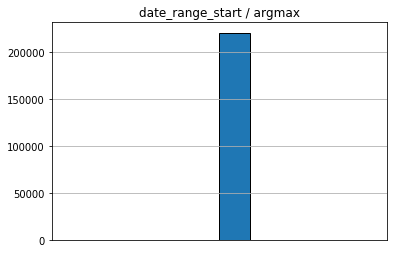

1538352000    220735
Name: date_range_start, dtype: int64


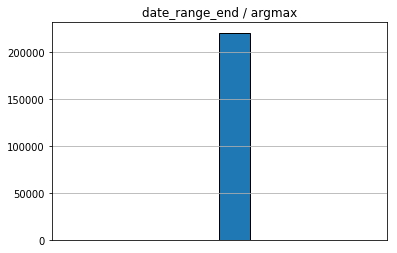

1541030400    220735
Name: date_range_end, dtype: int64


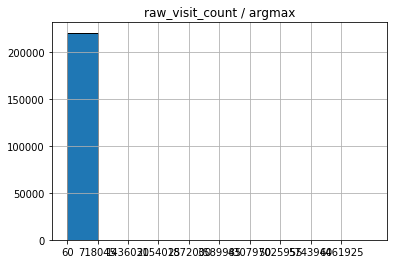

24531.0     121
12455.0      14
10888.0      14
21721.0      14
17801.0      13
16773.0      13
8524.0       13
15073.0      13
15161.0      13
11894.0      13
12980.0      13
17421.0      13
14482.0      13
12961.0      13
25796.0      13
16747.0      13
17567.0      13
15378.0      13
27618.0      13
21836.0      13
19911.0      13
15338.0      12
17419.0      12
11389.0      12
20390.0      12
12812.0      12
18861.0      12
25127.0      12
16338.0      12
14154.0      12
           ... 
60669.0       1
108235.0      1
60670.0       1
94432.0       1
91460.0       1
81846.0       1
88565.0       1
153513.0      1
85144.0       1
471996.0      1
143524.0      1
153526.0      1
59418.0       1
67664.0       1
350032.0      1
80070.0       1
88559.0       1
58315.0       1
123050.0      1
78798.0       1
177120.0      1
935.0         1
76759.0       1
124678.0      1
3878.0        1
76758.0       1
192152.0      1
21082.0       1
49295.0       1
11783.0       1
Name: raw_visit_count, L

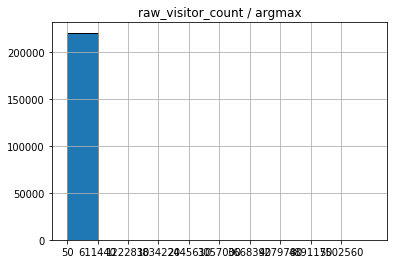

2292.0     145
3302.0      37
3106.0      36
3461.0      36
2444.0      36
2491.0      35
3255.0      35
2344.0      35
1615.0      35
1999.0      35
3584.0      35
1886.0      35
3230.0      35
3952.0      35
2754.0      35
2733.0      35
2133.0      35
2731.0      35
1866.0      34
2326.0      34
2894.0      34
2598.0      34
3334.0      34
3826.0      34
3530.0      34
2472.0      34
2315.0      33
3162.0      33
3799.0      33
2081.0      33
          ... 
25932.0      1
76992.0      1
38935.0      1
77913.0      1
13972.0      1
19479.0      1
67794.0      1
52301.0      1
46105.0      1
26585.0      1
55331.0      1
82152.0      1
25435.0      1
46109.0      1
38937.0      1
27661.0      1
34342.0      1
58470.0      1
23057.0      1
14898.0      1
55325.0      1
20594.0      1
25933.0      1
429.0        1
23708.0      1
32405.0      1
62495.0      1
163.0        1
55329.0      1
18294.0      1
Name: raw_visitor_count, Length: 41483, dtype: int64


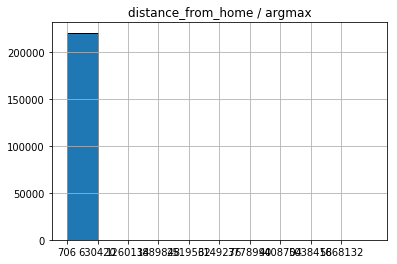

8345.0      247
8198.0       27
7422.0       27
8073.0       27
8337.0       25
8148.0       25
7579.0       24
8391.0       24
7494.0       24
8172.0       24
9230.0       23
7873.0       23
10270.0      23
7791.0       23
8202.0       23
6826.0       23
8802.0       23
8282.0       23
7485.0       23
8310.0       23
7469.0       23
7900.0       23
8554.0       22
7037.0       22
6817.0       22
8334.0       22
8038.0       22
10130.0      22
6692.0       22
8293.0       22
           ... 
38271.0       1
114093.0      1
325295.0      1
56666.0       1
114089.0      1
250454.0      1
71200.0       1
114101.0      1
162670.0      1
228242.0      1
228225.0      1
46672.0       1
46083.0       1
36398.0       1
456473.0      1
40675.0       1
162699.0      1
114117.0      1
81347.0       1
128311.0      1
128313.0      1
162683.0      1
456433.0      1
81340.0       1
38270.0       1
57053.0       1
142012.0      1
29289.0       1
191089.0      1
188528.0      1
Name: distance_from_home

In [17]:
hist_plot(df_argmax, "argmax")

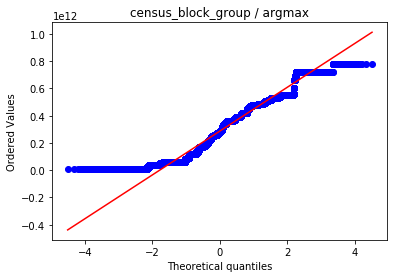

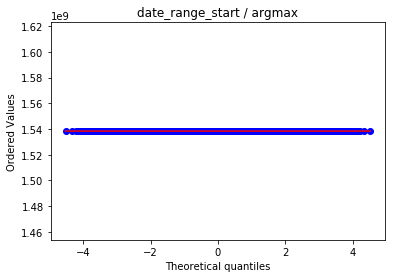

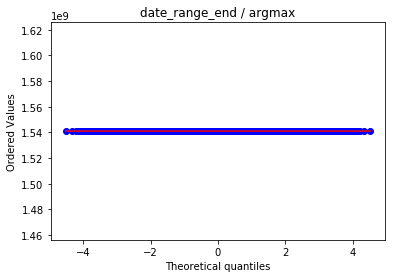

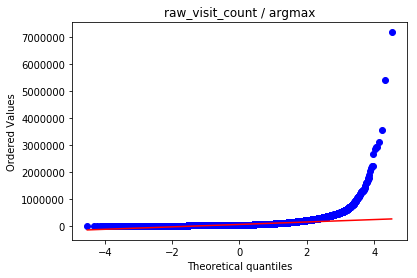

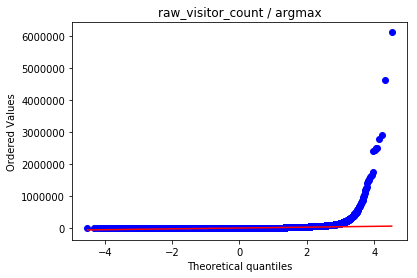

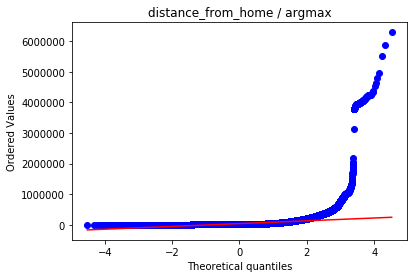

In [18]:
qq_plot(df_argmax, "argmax")

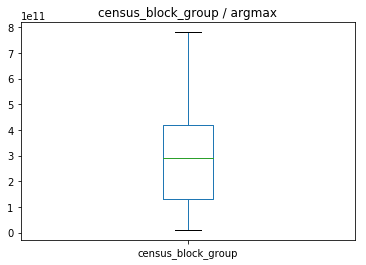

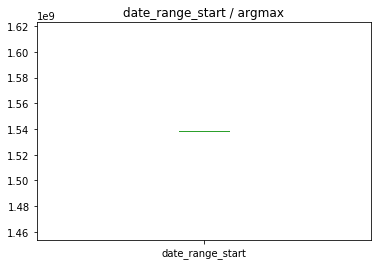

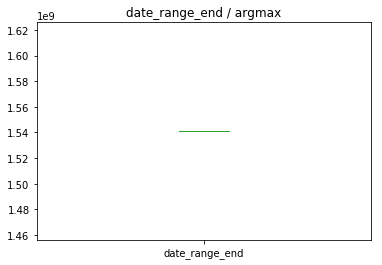

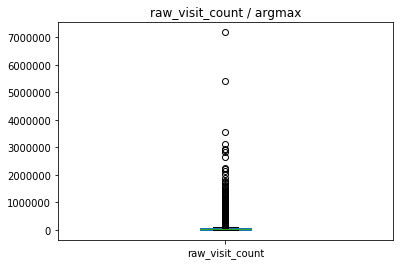

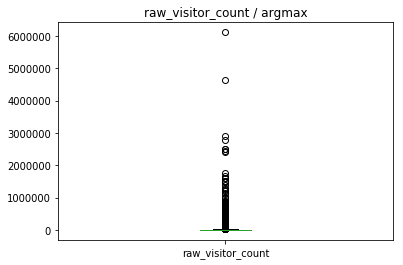

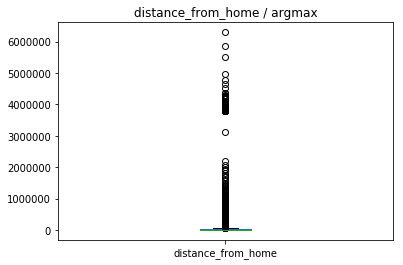

In [19]:
box_plot(df_argmax, "argmax")

通过属性的相关关系来填补缺失值，画图结果

In [20]:
#数值属性(通过属性的相关关系来填补缺失值)
df_relation = df[num_index_list]
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df_relation)
df_relation = imp.transform(df_relation)
# df_relation = IterativeImputer().fit_transform(df_relation)
df_relation = pd.DataFrame(df_relation, columns = num_index_list)

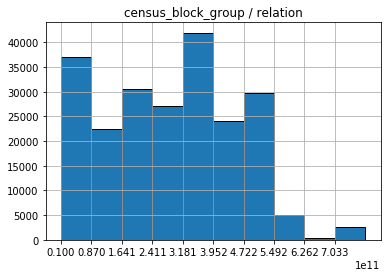

4.013422e+10    1
5.100109e+11    1
4.201101e+11    1
1.703180e+11    1
4.200760e+11    1
3.703501e+11    1
4.504100e+11    1
3.715704e+11    1
5.403303e+11    1
1.810500e+11    1
2.716307e+11    1
5.170003e+11    1
3.605500e+11    1
1.051030e+10    1
2.502354e+11    1
8.069003e+10    1
8.031004e+10    1
3.200301e+11    1
8.031007e+10    1
2.701596e+11    1
1.051031e+10    1
4.200595e+11    1
6.061021e+10    1
1.915300e+11    1
4.014301e+11    1
1.205701e+11    1
4.808503e+11    1
6.059110e+10    1
5.176002e+11    1
4.716502e+11    1
               ..
5.602500e+11    1
6.037107e+10    1
1.205701e+11    1
2.109300e+11    1
4.004138e+11    1
4.802912e+11    1
6.065042e+10    1
4.905721e+11    1
4.504500e+11    1
3.403126e+11    1
3.403118e+11    1
1.073010e+10    1
1.201104e+11    1
3.605500e+11    1
1.003011e+10    1
4.210103e+11    1
4.202930e+11    1
1.208601e+11    1
1.201106e+11    1
1.210303e+11    1
4.106703e+11    1
3.402971e+11    1
2.205102e+11    1
5.603300e+11    1
4.802702e+

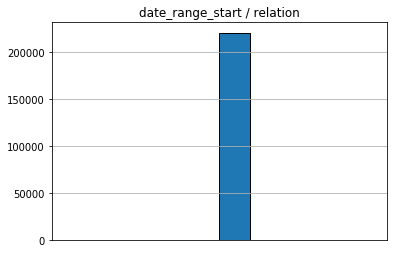

1.538352e+09    220735
Name: date_range_start, dtype: int64


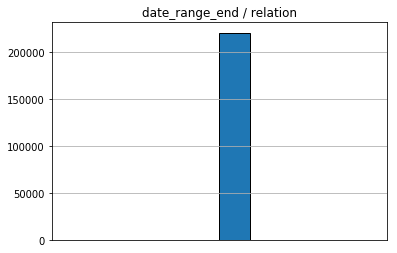

1.541030e+09    220735
Name: date_range_end, dtype: int64


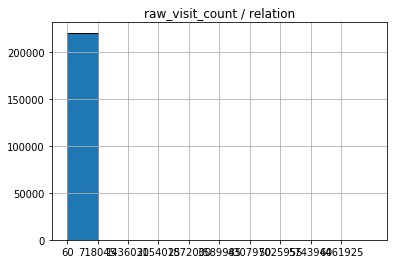

47930.65965     106
24531.00000      15
21721.00000      14
12455.00000      14
10888.00000      14
15378.00000      13
25796.00000      13
12961.00000      13
14482.00000      13
17421.00000      13
27618.00000      13
17801.00000      13
15161.00000      13
8524.00000       13
15073.00000      13
16773.00000      13
16747.00000      13
12980.00000      13
11894.00000      13
19911.00000      13
21836.00000      13
17567.00000      13
16987.00000      12
15653.00000      12
18861.00000      12
16338.00000      12
13479.00000      12
11696.00000      12
15061.00000      12
17222.00000      12
               ... 
60669.00000       1
108235.00000      1
60670.00000       1
94432.00000       1
91460.00000       1
81846.00000       1
88565.00000       1
153513.00000      1
85144.00000       1
471996.00000      1
143524.00000      1
153526.00000      1
59418.00000       1
67664.00000       1
350032.00000      1
80070.00000       1
88559.00000       1
58315.00000       1
123050.00000      1


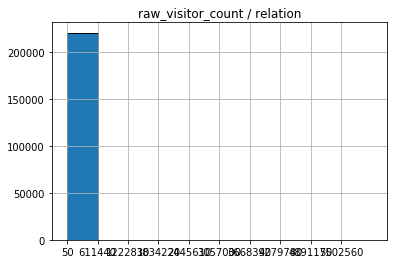

11820.319922    106
2292.000000      39
3302.000000      37
3461.000000      36
3106.000000      36
2444.000000      36
2344.000000      35
3230.000000      35
1615.000000      35
2754.000000      35
1999.000000      35
2733.000000      35
1886.000000      35
3584.000000      35
3255.000000      35
2491.000000      35
2731.000000      35
3952.000000      35
2133.000000      35
3530.000000      34
2472.000000      34
2894.000000      34
3334.000000      34
2598.000000      34
2326.000000      34
1866.000000      34
3826.000000      34
3162.000000      33
2429.000000      33
3974.000000      33
               ... 
25932.000000      1
76992.000000      1
38935.000000      1
77913.000000      1
13972.000000      1
19479.000000      1
67794.000000      1
52301.000000      1
46105.000000      1
26585.000000      1
55331.000000      1
82152.000000      1
25435.000000      1
46109.000000      1
38937.000000      1
27661.000000      1
34342.000000      1
58470.000000      1
23057.000000      1


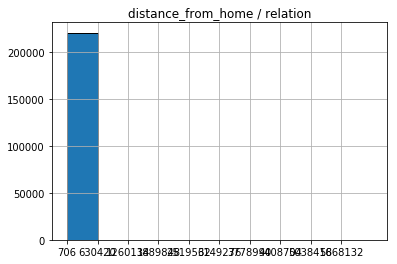

35112.803463     217
8345.000000       30
7422.000000       27
8073.000000       27
8198.000000       27
8148.000000       25
8337.000000       25
8172.000000       24
8391.000000       24
7494.000000       24
7579.000000       24
7469.000000       23
8202.000000       23
7900.000000       23
7873.000000       23
8802.000000       23
10270.000000      23
7485.000000       23
8282.000000       23
6826.000000       23
7791.000000       23
8310.000000       23
9230.000000       23
8343.000000       22
8334.000000       22
8038.000000       22
8554.000000       22
8293.000000       22
8057.000000       22
7500.000000       22
                ... 
114093.000000      1
325295.000000      1
56666.000000       1
114089.000000      1
250454.000000      1
71200.000000       1
134542.000000      1
456401.000000      1
57051.000000       1
46672.000000       1
128311.000000      1
46083.000000       1
36398.000000       1
456473.000000      1
40675.000000       1
162699.000000      1
114117.000000

In [21]:
hist_plot(df_relation, "relation")

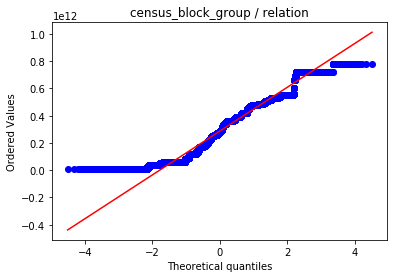

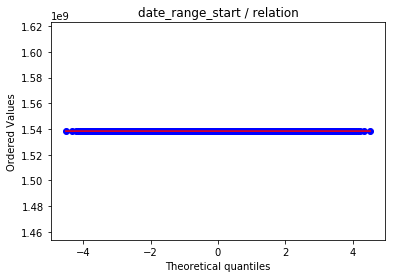

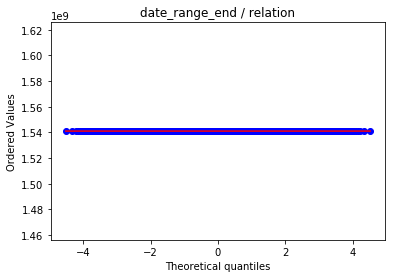

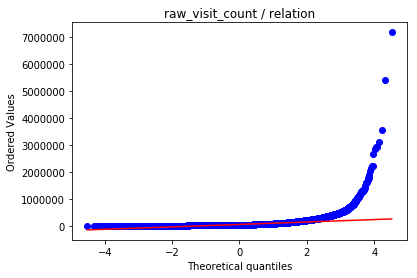

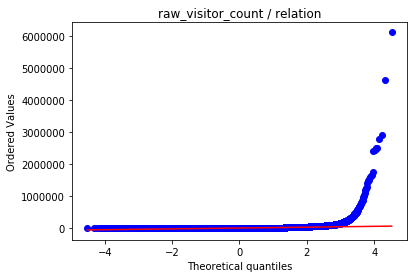

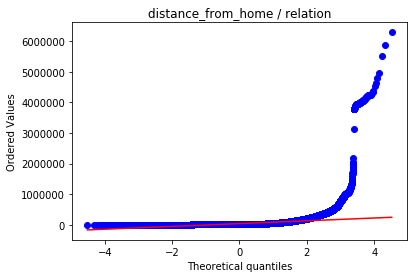

In [22]:
qq_plot(df_relation, "relation")

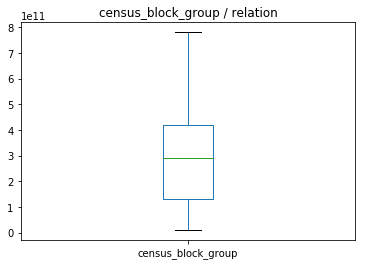

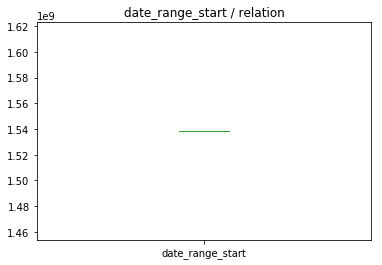

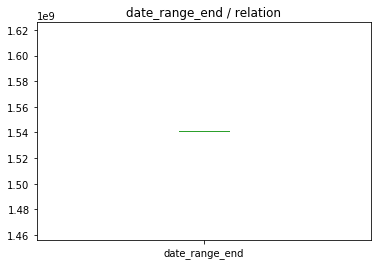

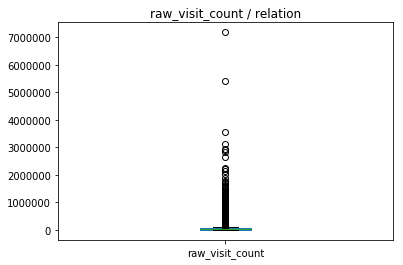

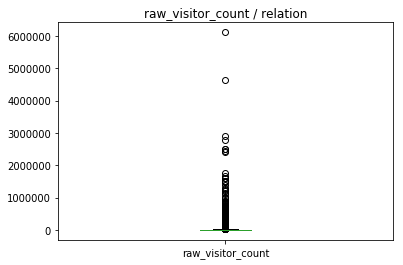

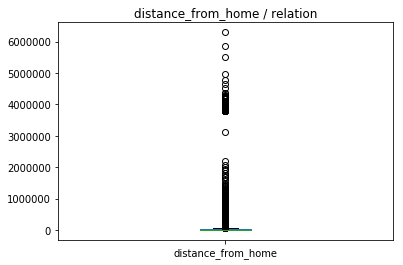

In [23]:
box_plot(df_relation, "relation")

通过数据对象之间的相似性来填补缺失值，画图结果

In [24]:
#数值属性(通过数据对象之间的相似性来填补缺失值)
df_similarity = df.copy()[num_index_list]
# df_similarity = KNN(k=1).fit_transform(df_similarity)
df_similarity = SoftImpute().fit_transform(df_similarity)
df_similarity = pd.DataFrame(df_similarity, columns = num_index_list)

[SoftImpute] Max Singular Value of X_init = 155355856550558.000000
[SoftImpute] Iter 1: observed MAE=1164125683.677046 rank=1
[SoftImpute] Iter 2: observed MAE=1164125689.449987 rank=1
[SoftImpute] Iter 3: observed MAE=1164125689.392983 rank=1
[SoftImpute] Iter 4: observed MAE=1164125689.327400 rank=1
[SoftImpute] Iter 5: observed MAE=1164125689.263124 rank=1
[SoftImpute] Iter 6: observed MAE=1164125689.200119 rank=1
[SoftImpute] Iter 7: observed MAE=1164125689.138369 rank=1
[SoftImpute] Iter 8: observed MAE=1164125689.077864 rank=1
[SoftImpute] Iter 9: observed MAE=1164125689.018556 rank=1
[SoftImpute] Iter 10: observed MAE=1164125688.960436 rank=1
[SoftImpute] Iter 11: observed MAE=1164125688.903471 rank=1
[SoftImpute] Iter 12: observed MAE=1164125688.847650 rank=1
[SoftImpute] Iter 13: observed MAE=1164125688.792937 rank=1
[SoftImpute] Iter 14: observed MAE=1164125688.739324 rank=1
[SoftImpute] Iter 15: observed MAE=1164125688.686769 rank=1
[SoftImpute] Iter 16: observed MAE=1164125

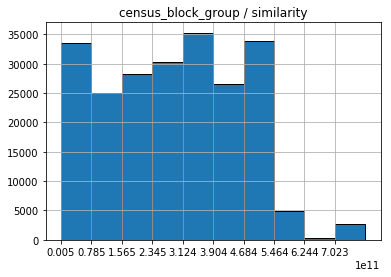

4.013422e+10    1
1.205701e+11    1
1.703180e+11    1
4.200760e+11    1
3.703501e+11    1
4.504100e+11    1
3.715704e+11    1
5.403303e+11    1
1.810500e+11    1
2.716307e+11    1
5.170003e+11    1
3.605500e+11    1
1.051030e+10    1
2.502354e+11    1
8.069003e+10    1
8.031004e+10    1
3.200301e+11    1
8.031007e+10    1
2.701596e+11    1
1.051031e+10    1
4.200595e+11    1
6.061021e+10    1
1.915300e+11    1
4.014301e+11    1
3.606102e+11    1
4.201101e+11    1
5.100109e+11    1
2.210595e+11    1
4.808503e+11    1
4.201101e+11    1
               ..
6.037107e+10    1
1.205701e+11    1
1.705195e+11    1
3.500100e+11    1
2.109300e+11    1
4.004138e+11    1
1.208601e+11    1
4.504500e+11    1
3.403126e+11    1
3.403118e+11    1
1.073010e+10    1
1.201104e+11    1
3.605500e+11    1
1.003011e+10    1
4.210103e+11    1
4.202930e+11    1
6.065042e+10    1
1.210303e+11    1
4.802912e+11    1
4.106703e+11    1
3.402971e+11    1
2.205102e+11    1
5.603300e+11    1
4.802702e+11    1
1.814101e+

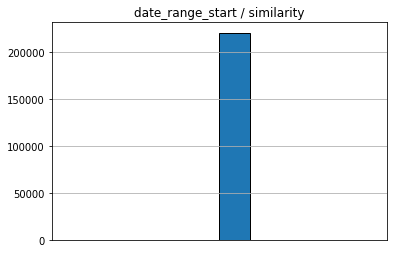

1.538352e+09    220735
Name: date_range_start, dtype: int64


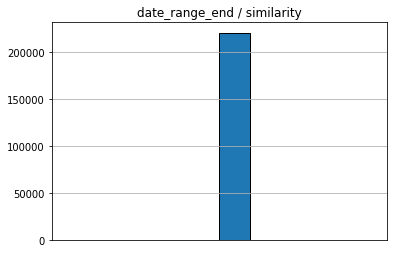

1.541030e+09    220735
Name: date_range_end, dtype: int64


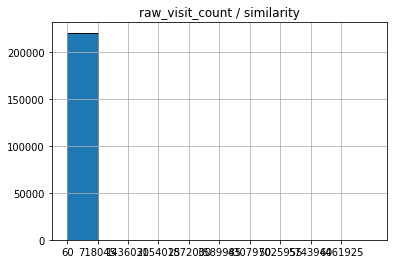

24531.0     15
12455.0     14
21721.0     14
10888.0     14
16747.0     13
15073.0     13
14482.0     13
27618.0     13
12961.0     13
8524.0      13
17567.0     13
21836.0     13
19911.0     13
15378.0     13
17801.0     13
16773.0     13
17421.0     13
25796.0     13
15161.0     13
11894.0     13
12980.0     13
20541.0     12
14154.0     12
11389.0     12
12768.0     12
13479.0     12
20390.0     12
25127.0     12
16338.0     12
13519.0     12
            ..
109660.0     1
331559.0     1
115673.0     1
165781.0     1
44016.0      1
115671.0     1
230952.0     1
68414.0      1
82901.0      1
2509.0       1
179050.0     1
77289.0      1
165798.0     1
82898.0      1
114248.0     1
115665.0     1
128626.0     1
62240.0      1
115664.0     1
165791.0     1
82895.0      1
90566.0      1
165789.0     1
63743.0      1
23498.0      1
75120.0      1
31583.0      1
82891.0      1
179048.0     1
162867.0     1
Name: raw_visit_count, Length: 93880, dtype: int64


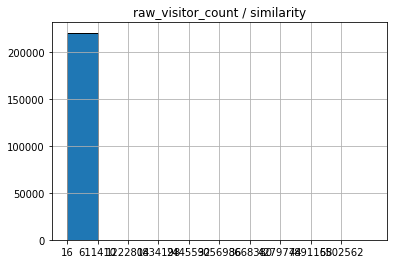

2292.0      39
3302.0      37
3106.0      36
3461.0      36
2444.0      36
3952.0      35
1615.0      35
2133.0      35
2344.0      35
2491.0      35
1886.0      35
2754.0      35
2731.0      35
3584.0      35
1999.0      35
2733.0      35
3255.0      35
3230.0      35
1866.0      34
2326.0      34
2472.0      34
2894.0      34
3334.0      34
3530.0      34
3826.0      34
2598.0      34
3264.0      33
2128.0      33
2320.0      33
2265.0      33
            ..
35068.0      1
31863.0      1
38818.0      1
32794.0      1
74419.0      1
26059.0      1
36004.0      1
74596.0      1
46983.0      1
20092.0      1
37207.0      1
41199.0      1
45051.0      1
30106.0      1
34152.0      1
30658.0      1
65962.0      1
30816.0      1
115169.0     1
90101.0      1
15222.0      1
44224.0      1
46985.0      1
53586.0      1
26372.0      1
60183.0      1
52994.0      1
31194.0      1
53916.0      1
30260.0      1
Name: raw_visitor_count, Length: 41589, dtype: int64


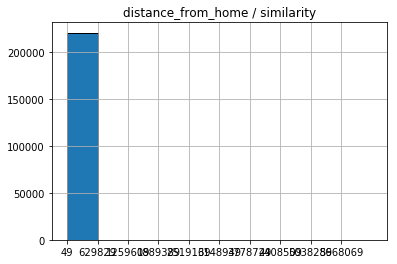

8345.0      30
8073.0      27
7422.0      27
8198.0      27
8148.0      25
8337.0      25
7579.0      24
8391.0      24
8172.0      24
7494.0      24
9230.0      23
10270.0     23
7469.0      23
6826.0      23
8202.0      23
7791.0      23
7900.0      23
8282.0      23
8802.0      23
8310.0      23
7873.0      23
7485.0      23
8293.0      22
7687.0      22
8044.0      22
7260.0      22
8675.0      22
6817.0      22
8554.0      22
8334.0      22
            ..
109873.0     1
516179.0     1
285240.0     1
173955.0     1
38551.0      1
154203.0     1
43284.0      1
86978.0      1
46896.0      1
49659.0      1
23718.0      1
38554.0      1
239487.0     1
106128.0     1
18602.0      1
77113.0      1
879046.0     1
120228.0     1
154225.0     1
347892.0     1
38832.0      1
57054.0      1
219753.0     1
109879.0     1
93641.0      1
51505.0      1
38555.0      1
439508.0     1
439507.0     1
188528.0     1
Name: distance_from_home, Length: 70774, dtype: int64


In [25]:
hist_plot(df_similarity, "similarity")

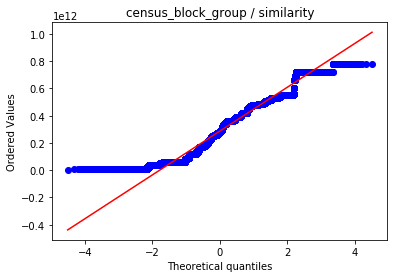

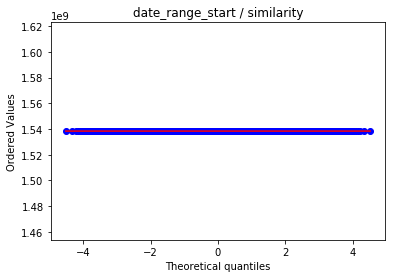

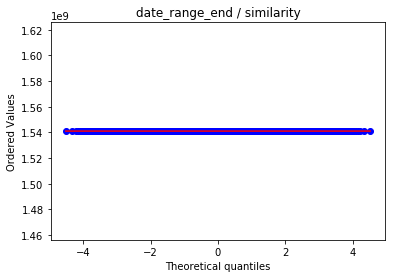

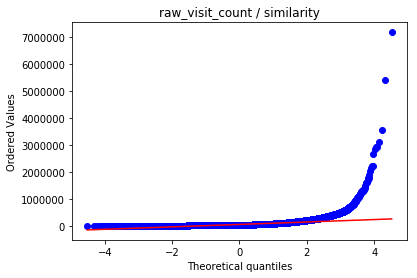

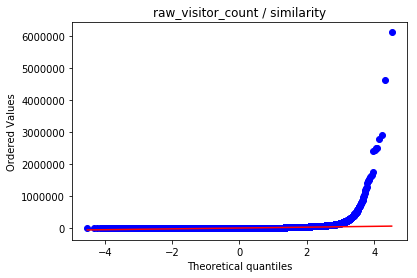

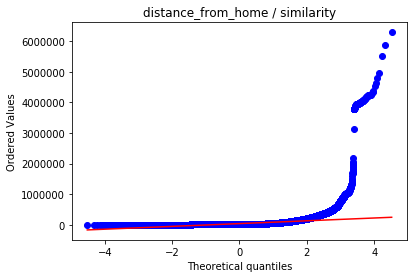

In [26]:
qq_plot(df_similarity, "similarity")

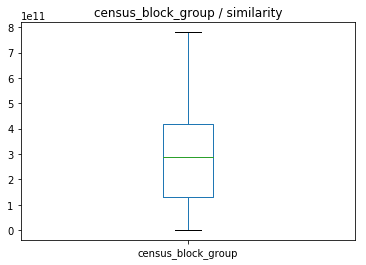

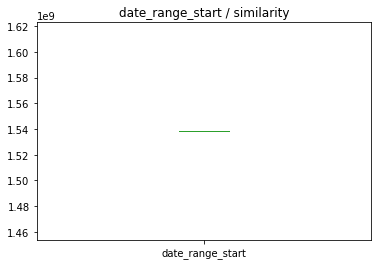

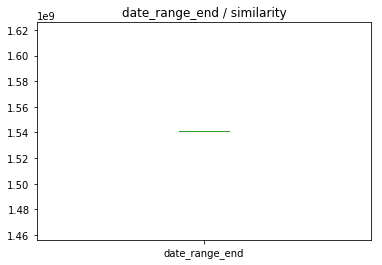

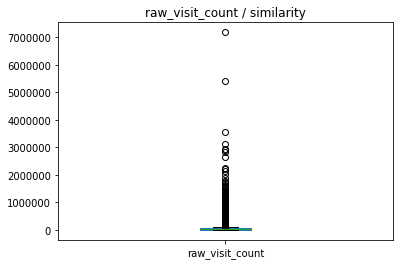

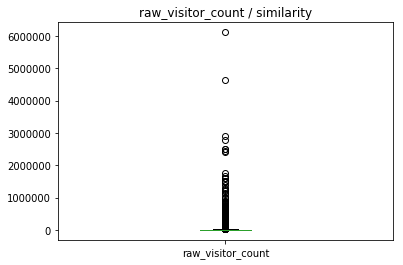

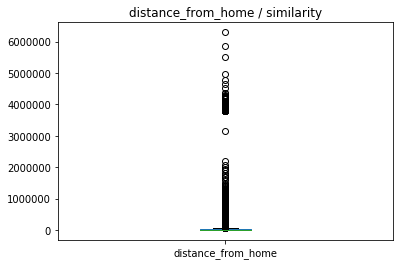

In [27]:
box_plot(df_similarity, "similarity")